In [1]:
import pandas as pd 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import torch
import math
import itertools

import torch.nn.functional as F


# Structure of Notebook:

### Data loading + Data preprocessing
- [ ] PV Data Loading 
- [ ] PV Data Preprocessing 
- [ ] Satellite Data Loading 
- [ ] Satellite Data Preprocessing 
- [ ] NWP Data Loading 
- [ ] NWP Data Preprocessing

### Dataset Generation (TODO)

### Models

======================================================================================

## PV Data Loading
We load in PV system data from the metadata.csv 

We load in PV generation data from the .netcdf file

Both sources of data can be found here: https://huggingface.co/datasets/openclimatefix/uk_pv

In [2]:
'''
    Relevant data for our model:
    
    ss_id : id number of the PV system. these are the keys in the netcdf file
    latitude_rounded : latitude of the PV system (I think degrees)
    longitude_rounded : longitude of the PV system (I think degrees)
    orientation : cardinal orientation of PV panels ? TODO: confirm
    tilt : tilt angle of the PV panels
'''
pv_metadata = pd.read_csv("../data/metadata.csv")
pv_metadata.head()     # Prints first 5 rows of metadata


,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [24]:
fn = '../data/pv.netcdf'
#ncf = nc.Dataset(fn)   # Using xarray to open files instead of netcdf for pipeline simplicity
ncf = xr.open_dataset(fn, engine="h5netcdf")
#print(ncf.keys())

In [5]:
list_of_pv_systems = list(ncf.keys())  # list of strings of PV system ss_id's

print(list_of_pv_systems)

['10003', '10004', '10005', '10048', '10049', '10063', '10064', '10082', '10086', '10131', '10149', '10150', '10167', '10168', '10169', '10190', '10205', '10206', '10207', '10222', '10254', '10278', '10280', '10361', '10366', '10367', '10425', '10426', '10437', '10438', '10440', '10466', '10497', '10509', '10511', '10512', '10513', '10523', '10528', '10531', '10532', '10533', '10547', '10548', '10585', '10586', '10589', '10595', '10619', '10620', '10630', '10631', '10639', '10640', '10648', '10649', '10650', '10685', '10686', '10689', '10692', '10693', '10702', '10704', '10791', '10792', '10793', '10794', '10835', '10837', '10838', '10840', '10841', '10842', '10843', '10844', '10890', '10929', '10973', '10974', '10975', '10976', '11040', '11042', '11151', '11153', '11166', '11174', '11175', '11176', '11287', '11401', '11438', '11441', '11465', '11466', '11494', '11522', '11558', '11573', '11590', '11591', '11628', '11630', '11655', '11656', '11657', '11685', '11687', '11688', '11712', 

In [9]:
on_pv_system = ncf[list_of_pv_systems[0]].to_dataframe()
on_pv_system = on_pv_system[on_pv_system.index < '2021-06-03']
on_pv_system = on_pv_system[on_pv_system.index > '2021-06-02 00:00:00']
print(on_pv_system.index)
on_pv = np.array(on_pv_system)
on_pv = list(itertools.chain(*on_pv))
print(len(on_pv))

DatetimeIndex(['2021-06-02 00:05:00', '2021-06-02 00:10:00',
               '2021-06-02 00:15:00', '2021-06-02 00:20:00',
               '2021-06-02 00:25:00', '2021-06-02 00:30:00',
               '2021-06-02 00:35:00', '2021-06-02 00:40:00',
               '2021-06-02 00:45:00', '2021-06-02 00:50:00',
               ...
               '2021-06-02 23:10:00', '2021-06-02 23:15:00',
               '2021-06-02 23:20:00', '2021-06-02 23:25:00',
               '2021-06-02 23:30:00', '2021-06-02 23:35:00',
               '2021-06-02 23:40:00', '2021-06-02 23:45:00',
               '2021-06-02 23:50:00', '2021-06-02 23:55:00'],
              dtype='datetime64[ns]', name='datetime', length=287, freq=None)
287


2021-06-02 00:10:00


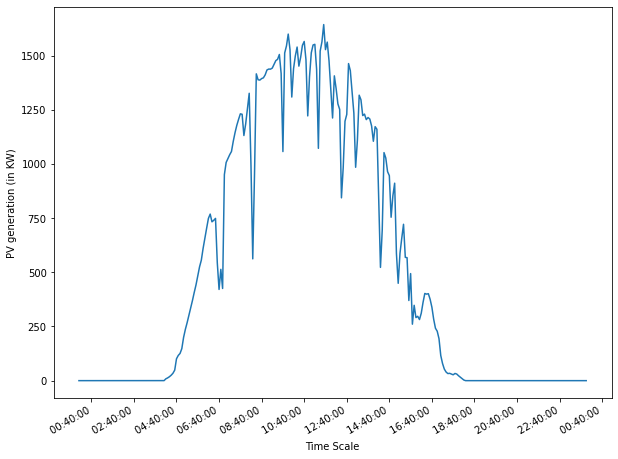

In [10]:
# Plot/visualize PV production for single system in one day
'''
'''
plt.figure(figsize=(10,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(" %H:%M:%S"))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=120))
x_dates = [dt.datetime.strptime(str(pd.Timestamp(d)), '%Y-%m-%d %H:%M:%S') for d in on_pv_system.index]
print(x_dates[1])
temp_x = np.linspace(1, len(on_pv), num=len(on_pv))
plt.plot(x_dates, on_pv)
plt.xlabel('Time Scale')
plt.ylabel('PV generation (in KW)')
plt.gcf().autofmt_xdate()
plt.show()


## PV Data Preprocessing
We will standardize all data using the calculated standard deviation from across all PV systems

In [ ]:
'''

model input: 
- date + time from which to forecast next 24h
- latitutde/longitude
- orientation/tilt
- kwp

model output:
- 24 hour generation forecast in increments of 15 min (CAN BE CHANGED)

Current TODO:

- run lat/lon/date through a trigonometric transformation to reduce endpoint singularities (https://arxiv.org/pdf/2011.06125.pdf)
- load in satellite image data, run it through normalization

'''

## Vision Data Loading
We load satellite imagery data from here https://console.cloud.google.com/storage/browser/public-datasets-eumetsat-solar-forecasting;tab=objects?prefix=&forceOnObjectsSortingFiltering=false

In [16]:
import xarray as xr
import cartopy.crs as ccrs  # CRS stands for "coordinate reference system"
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12)

SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr" 

In [22]:
dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr", 
    chunks="auto",  # Load the data as a Dask array.
)

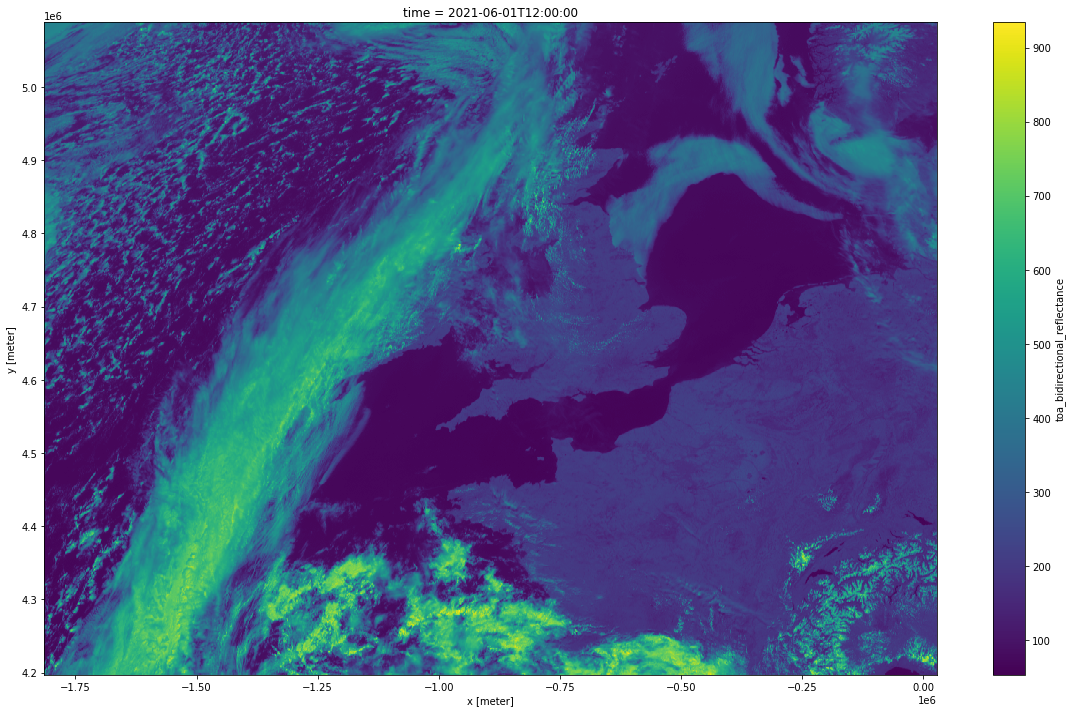

In [19]:
DATETIME_TO_PLOT = "2021-06-01 12:00"
data_array = dataset['data']
data_array.sel(time=DATETIME_TO_PLOT).plot();


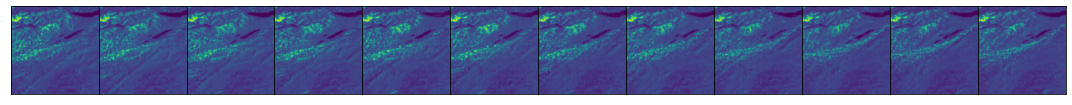

In [23]:
fig, ax = plt.subplots(1, 12, figsize=(15,3))

for i, d in enumerate(["2020-07-04 12:00", "2020-07-04 12:05", "2020-07-04 12:10", "2020-07-04 12:15", "2020-07-04 12:20", "2020-07-04 12:25", "2020-07-04 12:30", "2020-07-04 12:35", "2020-07-04 12:40", "2020-07-04 12:45", "2020-07-04 12:50", "2020-07-04 12:55"]):
    ax[i].imshow(dataset["data"].sel(time=d).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy(), cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

## Vision Data Preprocessing


## NWP Data Loading

## NWP Data Preprocessing


# Dataset Architecture

The current plan is to create input samples of size $X \in \mathbb{R}^{T \cdot f}$, where $T = $ number of input timesteps and $f$ = number of features. Inspiration from this paper: https://www.eng.uwo.ca/electrical/faculty/grolinger_k/docs/S2S-RNN1.pdf

Each row of $X$ will tentatively look like:

$$
[ \text{Longitude, Latitude, Orientation, Tilt, Month, Day (1-366), Day (1-31), Hour, Minute, Temperature, Humidity, PV generation}, \text{1-D embedding from CNN encoder of satellite image crop near the PV system } ]
$$

Target features will be $y \in \mathbb{R}^{N \cdot 1}$, where $N$ is the number of predicted timesteps from the model. This is subject to change with the incrementation/granularity we want our PV predictions (i.e. every 30/15/10/5 minutes). However, the goal is to always have a 24h forecast

$Y$ will look like: 

$$
Y = [\text{PV generation_1, PV generation_2, ... , PV generation_N}]^T
$$
